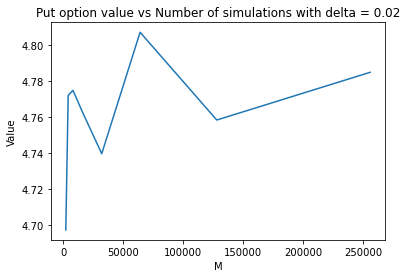

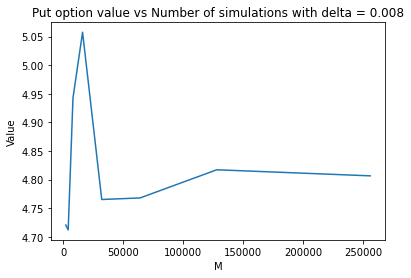

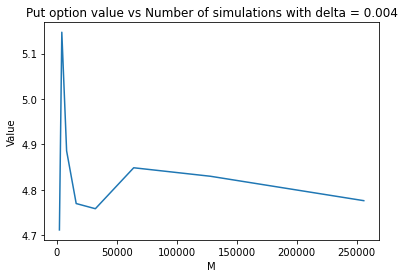

95% confidence intervals for delta = 0.004

2000 simulations

Estimated option value = 4.711747969215983

Lower bound: 4.319975330777577

Upper bound: 5.10352060765438


4000 simulations

Estimated option value = 5.14715828229438

Lower bound: 4.859238414208913

Upper bound: 5.4350781503798595


8000 simulations

Estimated option value = 4.885883809708127

Lower bound: 4.688849304727766

Upper bound: 5.082918314688481


16000 simulations

Estimated option value = 4.769829988870009

Lower bound: 4.631436496110028

Upper bound: 4.908223481630006


32000 simulations

Estimated option value = 4.758442704595666

Lower bound: 4.661041005636425

Upper bound: 4.855844403554934


64000 simulations

Estimated option value = 4.848641849231766

Lower bound: 4.778626832268407

Upper bound: 4.91865686619512


128000 simulations

Estimated option value = 4.829940366742155

Lower bound: 4.78059682142161

Upper bound: 4.879283912062655


256000 simulations

Estimated option value = 4.77617464148899

Lo

In [35]:
### QUESTION 1 ###


import math
import numpy as np
from matplotlib import pyplot as plt

opt_mean = np.zeros(8);
opt_std = np.zeros(8);
opt_index = 0;

# Calculates the put option value using Monte Carlo
# T - expiry time
# r - risk free rate
# S_init - current stock price 
# N_sim - number of simulations
# K - strike
# delt - time step size
# N - number of timesteps
def MCput(T, r, S_init, N_sim, K, delt, N):
    drift = r*delt
    
    S_old = S_init*np.ones(N_sim) 
    S_new = np.zeros(N_sim)
    
    for i in np.arange(N): #timestep loop
        # calculate sigma
        sigma = 20 / S_old;
        sigma_sqrt_delt = sigma*math.sqrt(delt);
        
        S_new = S_old + S_old*(drift + sigma_sqrt_delt * np.random.randn(N_sim));
        
        # check to ensure S_new cannot be < 0, set it to 10^8 if it is
        S_new = np.maximum(S_new, 10^(-8));
        S_old = S_new;
    
    # calculate value
    payoff = np.maximum(K - S_new, 0)
    payoff_sum = sum(payoff)
    V_S0 = np.exp(-r * T) * (payoff_sum / N_sim)
    
    # calculate mean and std dev of payoff only when delta = 1/250
    if (delt == 1/250):
        global opt_mean;
        global opt_std;
        global opt_index;
        opt_mean[opt_index] = np.mean(np.exp(-r * T) * payoff);
        opt_std[opt_index] = np.std(np.exp(-r * T) * payoff);
        opt_index += 1;
    
    
    return V_S0;
 
    
# Setup option values and plots
M = [2000, 4000, 8000, 16000, 32000, 64000, 128000, 256000]
delt = [5/250, 2/250, 1/250]
values = np.zeros(8);

for i in delt:
    index = 0
    for j in M:
        N = 1/i;
        value = MCput(1, 0.07, 100, j, 100, i, N);
        values[index] = value;
        index += 1;
        
    # plots 
    plt.plot(M, values)
    plt.title("Put option value vs Number of simulations with delta = " + str(i))
    plt.xlabel("M")
    plt.ylabel("Value")
    plt.show()
    
    # print 95% confidence interval table for smallest delta
    if (i == 1/250):
        index = 0;
        print("95% confidence intervals for delta = " + str(1/250) + "\n");
        for k in M:   
            lwr_bound = opt_mean[index] - (1.96*opt_std[index] / np.sqrt(k))
            upp_bound = opt_mean[index] + (1.96*opt_std[index] / np.sqrt(k))
            print(str(k) + " simulations\n")
            print("Estimated option value = " + str(values[index]) + "\n")
            print("Lower bound: " + str(lwr_bound) + "\n")
            print("Upper bound: " + str(upp_bound) + "\n\n")
            index += 1;
    
    values = np.zeros(8)
        
        


The values look to have a shorter range as delta increases. Also for lower deltas, it looks that the values may converge as the number of simulations increase, but as for higher deltas it looks that the values will diverge as the number of simulations increase.

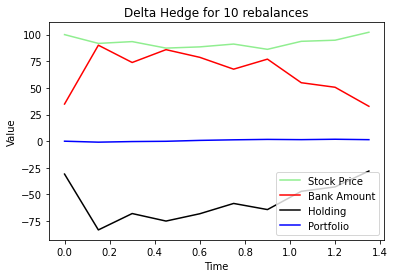

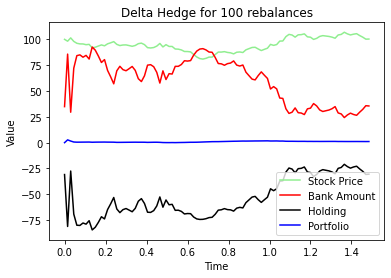

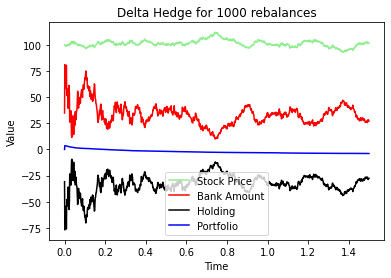

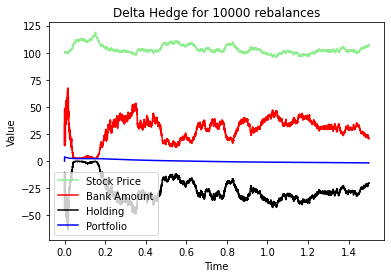

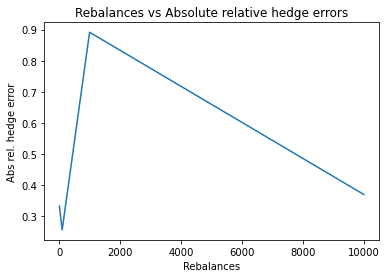

In [60]:
#adapted from Octave's financial toolkit
from scipy.stats import norm
import numpy as np
from matplotlib import pyplot as plt
    
def blsprice(Price, Strike, Rate, Time, Volatility):
    sigma_sqrtT = Volatility * np.sqrt (Time)

    d1 = 1 / sigma_sqrtT * (np.log(Price / Strike) + (Rate + Volatility**2 / 2) * Time)
    d2 = d1 - sigma_sqrtT

    phi1 = norm.cdf(d1)
    phi2 = norm.cdf(d2)
    disc = np.exp (-Rate * Time)
    F    = Price * np.exp ((Rate) * Time)

    Call = disc * (F * phi1 - Strike * phi2)
    Put  = disc * (Strike * (1 - phi2) + F * (phi1 - 1))
    return Call, Put
    
def blsdelta(Price, Strike, Rate, Time, Volatility):
    d1 = 1 / (Volatility * np.sqrt(Time)) * (np.log (Price / Strike) + (Rate + Volatility**2 / 2) * Time)

    phi = norm.cdf(d1)

    CallDelta = phi
    PutDelta = phi - 1
    return CallDelta, PutDelta


### QUESTION 2 ###


# deltahedge calculates the stochastic path for the stock price,
# risk free account, stock holding, and total port. value, using
# delta hedging
def deltahedge(S0, K, r, sigma, T, t_rebal, mu):
    # setup initial values
    delt = T / t_rebal;
    tn_rebal = np.arange(T, 0, -delt)
    
    pi = np.zeros(len(tn_rebal)) # portfolio value
    a = np.zeros(len(tn_rebal))  # amount of shares
    B = np.zeros(len(tn_rebal))  # amount in bank
    S = np.zeros(len(tn_rebal))  # stock prices
    hold = np.zeros(len(tn_rebal)) # stock holding
    relerr = 0; 
    
    a[0] = blsdelta(S0, K, r, T, sigma)[1]
    B[0] = blsprice(S0, K, r, T, sigma)[1] - blsdelta(S0, K, r, T, sigma)[1] * S0
    S[0] = S0
    hold[0] = a[0] * S[0]
    
    # loop through the rebalancing times 
    for i in np.arange(1, len(tn_rebal)):
        S[i] = S[i-1] * np.exp( ((mu - (sigma**2) / 2) * (delt)) + 
                                (sigma * np.random.randn() * np.sqrt(delt)) )
        val = blsprice(S[i], K, r, T - tn_rebal[i], sigma)[1];
        a[i] = blsdelta(S[i], K, r, T - tn_rebal[i], sigma)[1];
        B[i] = ( B[i-1] * np.exp(r * delt) ) - S[i] * (a[i] - a[i-1]);
        pi[i] = -val + a[i]*S[i] + B[i];
        
        hold[i] = a[i] * S[i];
    
    # relative hedging error
    rherror = np.exp(-r * T) * (pi[len(tn_rebal) - 1]) / np.abs(blsprice(S0, K, r, T, sigma)[1])
    
    
    return S, B, hold, pi, rherror



# setup plots
rebalances = [10, 100, 1000, 10000]
errors = np.zeros(4)
errindex = 0

for i in rebalances:
    delt = 1.5 / i;
    t = np.arange(0, 1.5, delt);
    dh = deltahedge(100, 100, 0.05, 0.15, 1.5, i, 0.09);
    S = dh[0]
    B = dh[1];
    hold = dh[2];
    pi = dh[3];
    errors[errindex] = np.abs(dh[4]);
    errindex += 1;
    
    # plot the stochastic paths
    plt.plot(t, S, color = "lightgreen", label = "Stock Price");
    plt.plot(t, B, color = "red", label = "Bank Amount");
    plt.plot(t, hold, color = "black", label = "Holding");
    plt.plot(t, pi, color = "blue", label = "Portfolio");
    plt.title("Delta Hedge for " + str(i) + " rebalances");
    plt.xlabel("Time");
    plt.ylabel("Value");
    plt.legend();
    plt.show();

plt.plot(rebalances, errors)
plt.title("Rebalances vs Absolute relative hedge errors")
plt.xlabel("Rebalances")
plt.ylabel("Abs rel. hedge error")
plt.show();


        





It looks that the portfolio value is always close to 0 throughout the entire time period. Also it looks that the rebalances vs absolute relative hedge error is inconsistent as there is no observable pattern in the plot.

CPPI simulation for pair: 0,1


Mean: 0.11054573376485259
Std Dev: 0.028546920850657603
VAR: 0.06416109724901088
CVAR: 0.05304734415474116


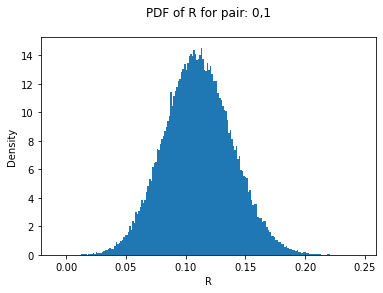

CPPI simulation for pair: 0,0.5


Mean: 0.10538877565773433
Std Dev: 0.014303296828924533
VAR: 0.08226926854398718
CVAR: 0.07666200671955574


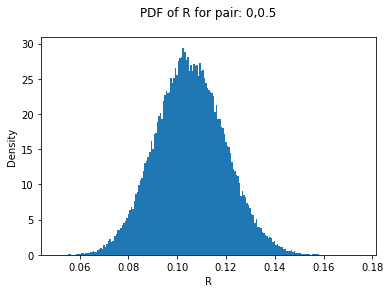

CPPI simulation for pair: 0,2


Mean: 0.12029591749041851
Std Dev: 0.056772274458184654
VAR: 0.02859641547290858
CVAR: 0.006177389547569256


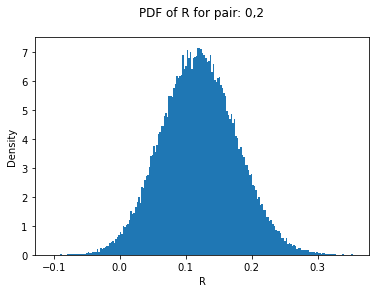

CPPI simulation for pair: 85,2


Mean: 0.10416563625855092
Std Dev: 0.011236213152943585
VAR: 0.08639971419450182
CVAR: 0.08228180562187835


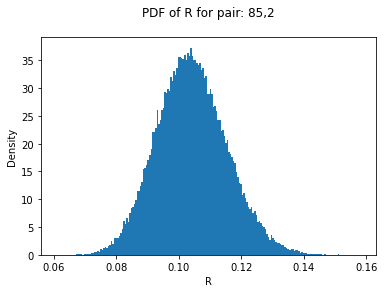

CPPI simulation for pair: 85,4


Mean: 0.1081513985990593
Std Dev: 0.022915168999908964
VAR: 0.07254333660712169
CVAR: 0.06492590277192817


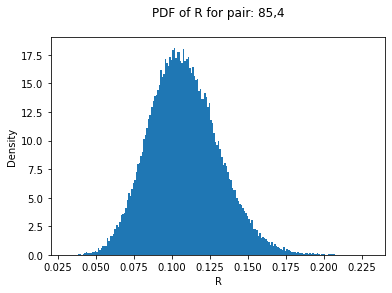

In [91]:
### QUESTION 3 ###

# cppi function simulates the CPPI strategy 
def cppi(F, M):
    T = 2 # investment horizon
    sigma = 0.3 # volatility
    mu = 0.1 # drift
    P0 = 100 # initial wealth
    r = 0.05 # risk free rate
    delt = 1/250 # rebalancing interval
    cash_0 = 100 # initial cash
    a0 = 0 # inital risky asset position
    S0 = 100 # initial risky asset price
    N = 80000 # number of simulations
    
    # inital values
    arg0 = 100 * np.exp(r * delt) - F
    a0 = M * (np.maximum(0, arg0)) / S0
    B0 = cash_0 * np.exp(r*delt) - (a0 * S0)
    
    a = np.ones(N) * a0
    b = np.ones(N) * B0
    S = np.ones(N) * S0 # stock prices for each simulation at time i
    
    # setup loop
    aprev = a
    ai = a
    Bi = b
    
    # timestep loop
    for i in np.arange(T/delt):
        S = S * np.exp( ((mu - (sigma**2) / 2) * delt) + 
                        (sigma * np.random.randn(N) * delt) );
        aprev = ai;
        arg = Bi * np.exp(r * delt) + (ai * S) - F;
        ai = M * (np.maximum(0, arg)) / S0;
        Bi = Bi * np.exp(r*delt) - (ai - aprev) * S;
    
    # portfolio value at T
    pi_t = Bi + (ai * S)
    
    # portfolio value at t=0
    pi_0 = b + (a * np.ones(N) * S0)
    
    # investment performance
    R = np.log(pi_t / pi_0)
    Rsorted = np.sort(R)
     
    return Rsorted


# setup cases for CPPI simulations
cases = [[0,1], [0,0.5], [0,2], [85,2], [85,4]]

for i in cases:
    cppi_case = cppi(i[0], i[1]);
    case_mean = np.mean(cppi_case);
    case_std = np.std(cppi_case);
    
    # get position for 95% VAR and CVAR to calculate them
    pos95 = int((80000 * 0.05) - 1);
    case_VAR = cppi_case[pos95];
    case_CVAR = np.mean(cppi_case[0:pos95]);
    
    # table containing mean, std, VAR, CVAR for the pair
    print("CPPI simulation for pair: " + str(i[0]) + "," + str(i[1]) + "\n\n");
    print("Mean: " + str(case_mean));
    print("Std Dev: " + str(case_std));
    print("VAR: " + str(case_VAR));
    print("CVAR: " + str(case_CVAR));
    
    # histogram PDE plot
    plt.hist(cppi_case, bins=200, density=1);
    plt.title("PDF of R for pair: " + str(i[0]) + "," + str(i[1]) + "\n");
    plt.xlabel("R");
    plt.ylabel("Density");
    plt.show();

    
        
        
    

It looks that the approximate probability density function of R for each case nearly follow a normal distribution, but each pair looks to have different ranges of the R value. 

The (F,M) pair (85,2) looks to have the highest 95% VAR and CVAR which suggests it is riskiest pair, while the pair (0,2) has the lowest 95% VAR and CVAR suggesting it is the better performing pair. It is also noticable that when M is higher along with a certain F value, the 95% VAR and CVAR is lower. So in my opinion, I believe this suggests that the higher M is and the lower F is, then the less risky the portfolio is.

Investment performance value for K = : 102


Mean: 0.08023843174534176
Std Dev: 0.15143438649774701
VAR: -0.2492248280660435
CVAR: -0.35889035713782064


Investment performance value for K = : 116


Mean: 0.0785341085441655
Std Dev: 0.2015305436340188
VAR: -0.3321414482114933
CVAR: -0.45009151711785184


Investment performance value for K = : 135


Mean: 0.0757879189350233
Std Dev: 0.2548516768099579
VAR: -0.40142762863303505
CVAR: -0.5312194182714456




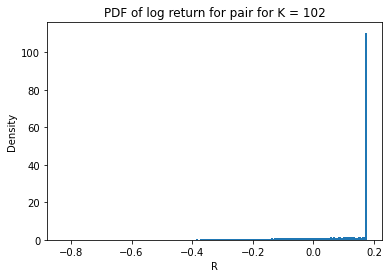

In [30]:
### QUESTION 4 ###

def blsprice(Price, Strike, Rate, Time, Volatility):
    sigma_sqrtT = Volatility * np.sqrt (Time)

    d1 = 1 / sigma_sqrtT * (np.log(Price / Strike) + (Rate + Volatility**2 / 2) * Time)
    d2 = d1 - sigma_sqrtT

    phi1 = norm.cdf(d1)
    phi2 = norm.cdf(d2)
    disc = np.exp (-Rate * Time)
    F    = Price * np.exp ((Rate) * Time)

    Call = disc * (F * phi1 - Strike * phi2)
    Put  = disc * (Strike * (1 - phi2) + F * (phi1 - 1))
    return Call, Put


# coveredcall calculates the investment performance using the
# covered call writing strategy
def coveredcall(K):
    sigma = 0.28 # volatility
    r = 0.05 # risk free rate
    T = 1.5 # time to expiry
    S0 = 100 # initial asset price
    S_init = 100 # inital investment
    mu = 0.08 # real world drift
    N = 80000 # number of simulations
    
    # value of call at t=0
    V0 = blsprice(S0, K, r, T, sigma)[0]
    
    # stock price at t=T for N simulations
    St = S0 * np.exp( ((mu - (sigma**2) / 2) * (T)) + 
                                (sigma * np.random.randn(N) * np.sqrt(T)) )
    
    # cash in bank at t=T
    bank_cash = V0 * np.exp(r * T) 
    
    # values of N simulations after selling stock then paying out call
    Sfinal = St 
    Sfinal[St > K] = K

    # return at t=T
    ret = np.log( (Sfinal + bank_cash) / S_init)
    ret_sorted = np.sort(ret)
    
    return ret_sorted


# setup simulations
strikes = [102, 116, 135]

for i in strikes:
    Rval = coveredcall(i);
    Rmean = np.mean(Rval);
    Rstd = np.std(Rval);
    
    # get index for 95% VAR and CVAR to calculate them
    pos95 = int((80000 * 0.05) - 1);
    RVAR = Rval[pos95];
    RCVAR = np.mean(Rval[0:pos95]);
    
    # table containing mean, std, VAR, CVAR 
    print("Investment performance value for K = : " + str(i) + "\n\n");
    print("Mean: " + str(Rmean));
    print("Std Dev: " + str(Rstd));
    print("VAR: " + str(RVAR));
    print("CVAR: " + str(RCVAR));
    print("\n");

    
# for smallest strike price (K = 102) generate PDF
smallK = coveredcall(102)

plt.hist(smallK, bins=200, density=1);
plt.title("PDF of log return for pair for K = 102");
plt.xlabel("R");
plt.ylabel("Density");
plt.show();
    
    

The 95% VAR and CVAR for each case are negative which suggests that the covered call writing strategy is very risky. The PDF for K = 102 looks to be very skewed to the right, and this suggests that the strategy provides positive returns most of the time.

In [ ]:
1+1